# __MBAR Analysis__

- Copy this noteboook/script to the `mbar/` directory of your project. 

- Includes sliding window (~rolling uncertainty) approach

- Change simulation parameters, and then run all cells



In [7]:

import os, sys
from glob import glob
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.utils import resample

import pymbar
from pymbar.mbar_pmf import mbar_pmf

import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.figsize'] = (5, 3.33)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.25


In [8]:
# Simulation Parameters

n_windows = 42          # Total number of umbrella windows
cv_min = -1.90          # Restraint in first window
cv_max = 2.20           # Restraint in last window
force_constant = 300.0  # Multiply 'rk2'/'rk3' by 2 (in cv.rst this is rk2=150.0)


In [9]:

# Reference restraint values
val0_k = np.linspace(cv_min, cv_max, n_windows)

# Restraint force values ('rk2'/'rk3')
K_k = np.ones(n_windows) * force_constant        

# Number of bins 
nbins = n_windows - 1


In [10]:

def output_directory(dirname="results"):
    """
    Create a new directory to save the results. Index directories by number of runs.
    """
    number = len(glob(f'{dirname}*'))
    output_dirname = f'{dirname}{number}'
    os.makedirs(output_dirname, exist_ok=True)
    return output_dirname


def save_dataframe(outdir, time, dg):
    """
    Save rolling window to CSV file
    """
    df = pd.DataFrame(
        {'Time (ps)': np.array(time),
         'Free Energy Barrier (kcal/mol)': np.array(dg),
         })
    df.to_csv(f'{outdir}/pmf-dataframe.csv')
    # df.to_latex(f'{outdir}/pmf-dataframe.tex', column_format='ccc',index=False)


def plot_mbar(outdir, ref=["freefile_mbar_step6.00"]):
    """
    Plot free energy profiles

    Need to correct 'time' variable... legend etc.
    """
    fnames = sorted(glob(f'{outdir}/*'))
    arr = ref + fnames

    time = []
    dg = []
    colors = []
    for i in range(len(arr)):
        initial = np.loadtxt(arr[i])

        # name = arr[i].split('_')[2]
        # t0 = name.split('-')[0]
        # ti = name.split('-')[1]
        # lab = str('%s - %s ps' % (t0, ti))
        time.append(i) 
        fe = float(initial[:,1].max() - initial[:10,1].min())
        er = float(initial[initial[:,1].argmax()][2])
        dg.append(str('%.1f ± %.1f' % (fe,er)))

        plt.errorbar(initial[:,0], initial[:,1] - initial[:10,1].min(), yerr=initial[:,2])
        # colors.append(np.array(plt.color_sequences)[i])

    # plt.legend(ncol=1, bbox_to_anchor = (1.3, 0.6), loc='center right', frameon=False, alignment='left')
    plt.xlabel("d1 - d2 (Å)")
    plt.ylabel("Potential of Mean Force (kcal/mol)")
    plt.savefig(f'{outdir}/pmf-sliding.png')
    
    # Save table
    save_dataframe(outdir=f'{outdir}', time=time, dg=dg)


def load_cvs_from(window, step_number="step6"):
    """
    Load the CV values from the equilibration files. Change 'usecols=1' if necessary
    """
    fnames = sorted(glob('../%02d/%s.0?_equilibration.cv' % (window, step_number)))
    array = [np.loadtxt(f, usecols=1)[::] for f in fnames[:]]
    return array
    

def concatenate_arrays(array, start=0, stop=None):
    """
    Concatenate arrays and return a slice of the concatenated array.
    """
    return np.concatenate(array)[start:stop]
        
        
def length_of_arrays(arrays):
    """
    Count number CV values and find the window with least CVs. This will be the cutoff for windows that are a few steps ahead 
    """
    length = []
    for i in arrays:
        length.append(len(i))
    return min(length)


def subsample_data(val_kn):    
    """
    Subsample correlated data using PyMBAR.
    """
    for i in range(len(val_kn)):
        print("Window %02d:" % i, pymbar.timeseries.subsampleCorrelatedData(val_kn[i], conservative=True))



def run_mbar(val_kn, outdir="results", filename="freefile_mbar", frame_number=None):
    """
    Estimate the free energy profile using MBAR.

          val_kn (list of arrays )   : Array has shape  -- [ n_windows x CV values ]
          outdir (results directory) : Directory to save results, new folders are indexed
        filename (MBAR energies)     : NumPy file with MBAR energies / errors
    frame_number (integer or None)   : Frame number of start frame in sliding uncertainty calculation
    """

    # Print subsampled correleted data, check for number of states !!!
    subsample_data(val_kn)

    # Compute MBAR
    mbar = mbar_pmf(val_kn, val0_k, K_k, force_constant)
    bin_centers, f_i, df_i, reweighting_entropy = mbar.get_pmf(cv_min, cv_max, nbins)
    bin_centers, f_i, df_i, reweighting_entropy = mbar.get_pmf(cv_min, cv_max, nbins, uncertainties='from-specified', pmf_reference=f_i[:20].argmin())
    
    if frame_number is None:
        # Save freefile_mbar from all step6 trajectories 
        np.savetxt(f'{outdir}/{filename}', np.column_stack((bin_centers, f_i, df_i)))
    else:
        # Save freefile_mbar[Start frame Number] from sliding uncertainty
        np.savetxt(f'{outdir}/{filename}{frame_number}', np.column_stack((bin_centers, f_i, df_i)))
        


def estimate_free_energy(windows, slide_by=5, dt=0.001, save_freq=10):
    """
    Two approaches:
        1. All trajectories (for each window) are concatenate and used to estimate the free energy profile
            - Set 'slide_by=0' to run analysis on all trajectories.
        2. Slide along a moving window (not umbrella window, but segment/portion of trajectory) to estimate the free energy profiles
            - See how free energy profile converges over simulation time
            - Set 'slide_by=5' to run analysis on sliding window of 5 ps.

      windows (integer)    : Total number of umbrella windows
     slide_by (picosecond) : Calculate MBAR via sliding window, e.g. calculate every 5 ps (segment) with entire trajectory
           dt (picosecond) : Integration timestep (usually 0.001 ps ~ 1 fs)
    save_freq (time-step)  : Saving frequency of CV values during simulation (usually 10 steps ~ 0.01 ps)
    """

    if slide_by == 0:
        # Option 1
        out = output_directory()

        val_kn = []
        for window in range(windows):
            arrays = load_cvs_from(window)
            val_kn.append(np.concatenate(arrays))
        run_mbar(val_kn, outdir=f'{out}')

        plot_mbar(outdir=f'{out}')

    else:
        # Option 2 
        out = output_directory()

        # Convert ps to step, adjust for number of CV values in *.cv
        slide = int(slide_by / dt / save_freq) 
       
       # Get smallest number of CV values for analysis
        max_length=length_of_arrays([np.concatenate(load_cvs_from(w)) for w in range(windows)])

        for j in range(0, max_length, slide):
            val_kn = []
            for w in range(windows):
                arrays = load_cvs_from(w)
                val_kn.append(concatenate_arrays(arrays, start=j, stop=j+slide))
            run_mbar(val_kn, outdir=f'{out}', frame_number='%04d' % j)

        plot_mbar(outdir=f'{out}')
        

Window 00: range(0, 8008, 2)
Window 01: range(0, 8008, 2)
Window 02: range(0, 8008, 2)
Window 03: range(0, 8008, 2)
Window 04: range(0, 8008, 2)
Window 05: range(0, 8008, 2)
Window 06: range(0, 8008, 2)
Window 07: range(0, 8008, 2)
Window 08: range(0, 8008, 2)
Window 09: range(0, 8008, 2)
Window 10: range(0, 8008, 2)
Window 11: range(0, 8008, 2)
Window 12: range(0, 8008, 2)
Window 13: range(0, 8008)
Window 14: range(0, 8008)
Window 15: range(0, 8008)
Window 16: range(0, 8008)
Window 17: range(0, 8008, 2)
Window 18: range(0, 8008, 4)
Window 19: range(0, 7024, 4)
Window 20: range(0, 7023, 2)
Window 21: range(0, 6636, 2)
Window 22: range(0, 6630, 2)
Window 23: range(0, 7026, 2)
Window 24: range(0, 7027, 2)
Window 25: range(0, 7026, 2)
Window 26: range(0, 6639, 2)
Window 27: range(0, 6631, 2)
Window 28: range(0, 7033, 2)
Window 29: range(0, 7034, 2)
Window 30: range(0, 7035, 2)
Window 31: range(0, 7035, 2)
Window 32: range(0, 7035, 2)
Window 33: range(0, 7038, 2)
Window 34: range(0, 7038, 

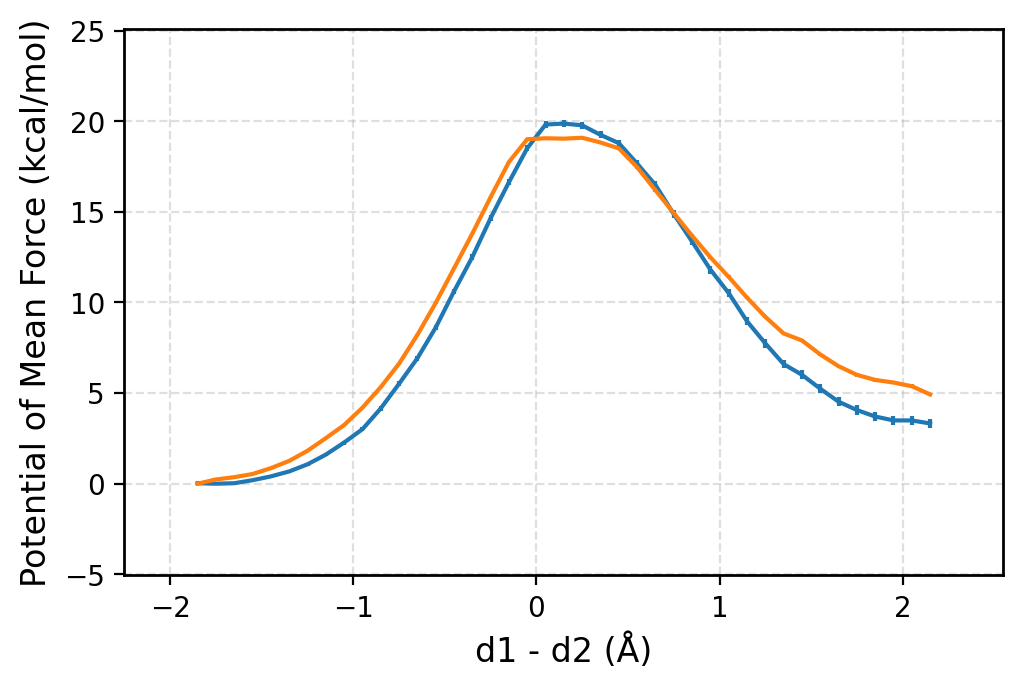

In [11]:
# Plot using all CV values

estimate_free_energy(n_windows, slide_by=0)


Window 00: range(0, 500, 2)
Window 01: range(0, 500, 2)
Window 02: range(0, 500, 2)
Window 03: range(0, 500, 2)
Window 04: range(0, 500, 2)
Window 05: range(0, 500, 2)
Window 06: range(0, 500, 2)
Window 07: range(0, 500, 2)
Window 08: range(0, 500, 2)
Window 09: range(0, 500, 2)
Window 10: range(0, 500, 2)
Window 11: range(0, 500, 2)
Window 12: range(0, 500, 2)
Window 13: range(0, 500)
Window 14: range(0, 500)
Window 15: range(0, 500)
Window 16: range(0, 500)
Window 17: range(0, 500)
Window 18: range(0, 500, 3)
Window 19: range(0, 500, 16)
Window 20: range(0, 500, 2)
Window 21: range(0, 500, 2)
Window 22: range(0, 500, 2)
Window 23: range(0, 500, 3)
Window 24: range(0, 500, 2)
Window 25: range(0, 500, 3)
Window 26: range(0, 500, 2)
Window 27: range(0, 500, 2)
Window 28: range(0, 500, 2)
Window 29: range(0, 500, 2)
Window 30: range(0, 500, 2)
Window 31: range(0, 500, 2)
Window 32: range(0, 500, 2)
Window 33: range(0, 500, 2)
Window 34: range(0, 500, 3)
Window 35: range(0, 500, 2)
Window

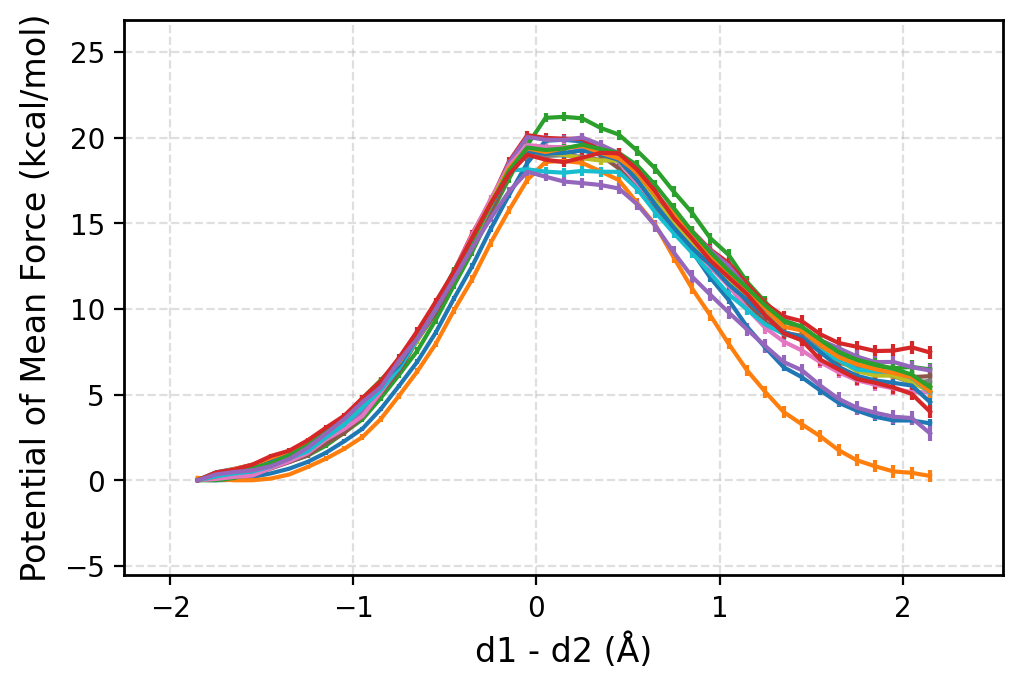

In [12]:
# Plot using 5 ps segments

estimate_free_energy(n_windows, slide_by=5)
